In [36]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [37]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/count_data/'

In [38]:
figname = 'model_4_calibration_test'

In [39]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'wasting_transition_count.csv',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [40]:
wasting_pt = pd.read_csv(output_dir +'disease_state_person_time.csv')
wasting_pt

Unnamed: 0     sex  year                   cause            measure  \
0               0  female  2022      diarrheal_diseases  state_person_time   
1               1  female  2022      diarrheal_diseases  state_person_time   
2               2  female  2022      diarrheal_diseases  state_person_time   
3               3  female  2022      diarrheal_diseases  state_person_time   
4               4  female  2022      diarrheal_diseases  state_person_time   
...           ...     ...   ...                     ...                ...   
51835       51835    male  2026  susceptible_to_measles  state_person_time   
51836       51836    male  2026  susceptible_to_measles  state_person_time   
51837       51837    male  2026  susceptible_to_measles  state_person_time   
51838       51838    male  2026  susceptible_to_measles  state_person_time   
51839       51839    male  2026  susceptible_to_measles  state_person_time   

       input_draw           scenario         value  \
0              29           baseline      3.043121   
1              29           baseline      0.924025   
2              29           baseline      0.386037   
3              29           baseline      0.076660   
4              29           baseline     18.939083   
...           ...                ...           ...   
51835         946  wasting_treatment    213.008898   
51836         946  wasting_treatment  23187.533196   
51837         946  wasting_treatment   6728.164271   
51838         946  wasting_treatment   1664.896646   
51839         946  wasting_treatment    334.335387   

                      wasting_state              age  
0      susceptible_to_child_wasting   early_neonatal  
1                mild_child_wasting   early_neonatal  
2       moderate_acute_malnutrition   early_neonatal  
3         severe_acute_malnutrition   early_neonatal  
4      susceptible_to_child_wasting    late_neonatal  
...                             ...              ...  
51835     severe_acute_malnutrition  12_to_23_months  
51836  susceptible_to_child_wasting           2_to_4  
51837            mild_child_wasting           2_to_4  
51838   moderate_acute_malnutrition           2_to_4  
51839     severe_acute_malnutrition           2_to_4  

[51840 rows x 10 columns]

# verify person time does not vary across different observers 

In [41]:
cols = ['input_draw','scenario','sex','age']

wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv').groupby(cols).sum()[['value']]
stunting_pt = pd.read_csv(output_dir +'stunting_state_person_time.csv').groupby(cols).sum()[['value']]
disease_pt = pd.read_csv(output_dir +'disease_state_person_time.csv')
disease_pt['cause'] = disease_pt.cause.str.replace('susceptible_to_','')
disease_pt = disease_pt.groupby(cols+['cause']).sum()[['value']].reset_index()
disease_pt['value'] = disease_pt['value'].round(0)
stunting_pt['value'] = stunting_pt['value'].round(0)
wasting_pt['value'] = wasting_pt['value'].round(0)
disease_pt.head()

input_draw  scenario     sex              age  \
0          29  baseline  female       1-5_months   
1          29  baseline  female       1-5_months   
2          29  baseline  female       1-5_months   
3          29  baseline  female  12_to_23_months   
4          29  baseline  female  12_to_23_months   

                          cause    value  
0            diarrheal_diseases  21831.0  
1  lower_respiratory_infections  21831.0  
2                       measles  21831.0  
3            diarrheal_diseases  51091.0  
4  lower_respiratory_infections  51091.0

In [42]:
assert np.all(disease_pt.loc[disease_pt.cause=='diarrheal_diseases'].drop(columns='cause').set_index(cols) 
        == disease_pt.loc[disease_pt.cause=='lower_respiratory_infections'].drop(columns='cause').set_index(cols))

assert np.all(disease_pt.loc[disease_pt.cause=='diarrheal_diseases'].drop(columns='cause').set_index(cols) 
        == disease_pt.loc[disease_pt.cause=='measles'].drop(columns='cause').set_index(cols))

assert np.all(disease_pt.loc[disease_pt.cause=='diarrheal_diseases'].drop(columns='cause').set_index(cols) 
        == wasting_pt)

assert np.all(disease_pt.loc[disease_pt.cause=='diarrheal_diseases'].drop(columns='cause').set_index(cols) 
        == stunting_pt)

In [43]:
wasting_pt.head()

value
input_draw scenario sex    age                      
29         baseline female 1-5_months        21831.0
                           12_to_23_months   51091.0
                           2_to_4           148521.0
                           6-11_months       25722.0
                           early_neonatal     1004.0

# Annual incident cases of wasting

In [44]:
wasting_transitions = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns='Unnamed: 0')
wasting_transitions = wasting_transitions.loc[wasting_transitions.age.isin(['6-11_months',
       '12_to_23_months', '2_to_4'])]
wasting_transitions = wasting_transitions.groupby(['input_draw',
                                                   'scenario',
                                                   'measure']).sum().drop(columns='year')
pt = wasting_pt.reset_index().loc[wasting_pt.reset_index().age.isin(['6-11_months',
       '12_to_23_months', '2_to_4'])].groupby(['input_draw',
                                               'scenario'
                                              ]).sum()
wasting_incidence = wasting_transitions / pt #* 100_000
wasting_incidence = wasting_incidence.groupby([
    'scenario',
    'measure']).describe(percentiles=[0.025,0.975])
wasting_incidence

value  \
                                                                     count   
scenario          measure                                                    
baseline          mild_child_wasting_to_moderate_acute_malnutriti...  12.0   
                  mild_child_wasting_to_susceptible_to_child_wast...  12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti...  12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal...  12.0   
                  severe_acute_malnutrition_to_mild_child_wasting...  12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal...  12.0   
                  susceptible_to_child_wasting_to_mild_child_wast...  12.0   
sqlns             mild_child_wasting_to_moderate_acute_malnutriti...  12.0   
                  mild_child_wasting_to_susceptible_to_child_wast...  12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti...  12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal...  12.0   
                  severe_acute_malnutrition_to_mild_child_wasting...  12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal...  12.0   
                  susceptible_to_child_wasting_to_mild_child_wast...  12.0   
wasting_treatment mild_child_wasting_to_moderate_acute_malnutriti...  12.0   
                  mild_child_wasting_to_susceptible_to_child_wast...  12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti...  12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal...  12.0   
                  severe_acute_malnutrition_to_mild_child_wasting...  12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal...  12.0   
                  susceptible_to_child_wasting_to_mild_child_wast...  12.0   

                                                                                \
                                                                          mean   
scenario          measure                                                        
baseline          mild_child_wasting_to_moderate_acute_malnutriti...  0.436773   
                  mild_child_wasting_to_susceptible_to_child_wast...  2.845974   
                  moderate_acute_malnutrition_to_mild_child_wasti...  0.419301   
                  moderate_acute_malnutrition_to_severe_acute_mal...  0.101832   
                  severe_acute_malnutrition_to_mild_child_wasting...  0.030274   
                  severe_acute_malnutrition_to_moderate_acute_mal...  0.075840   
                  susceptible_to_child_wasting_to_mild_child_wast...  2.833177   
sqlns             mild_child_wasting_to_moderate_acute_malnutriti...  0.391639   
                  mild_child_wasting_to_susceptible_to_child_wast...  2.908327   
                  moderate_acute_malnutrition_to_mild_child_wasti...  0.364393   
                  moderate_acute_malnutrition_to_severe_acute_mal...  0.078777   
                  severe_acute_malnutrition_to_mild_child_wasting...  0.048454   
                  severe_acute_malnutrition_to_moderate_acute_mal...  0.036269   
                  susceptible_to_child_wasting_to_mild_child_wast...  2.889081   
wasting_treatment mild_child_wasting_to_moderate_acute_malnutriti...  0.445986   
                  mild_child_wasting_to_susceptible_to_child_wast...  2.884490   
                  moderate_acute_malnutrition_to_mild_child_wasti...  0.410032   
                  moderate_acute_malnutrition_to_severe_acute_mal...  0.087330   
                  severe_acute_malnutrition_to_mild_child_wasting...  0.053843   
                  severe_acute_malnutrition_to_moderate_acute_mal...  0.038917   
                  susceptible_to_child_wasting_to_mild_child_wast...  2.867806   

                                                                                \
                                                                           std   
scenario          measure                                      

In [45]:
wasting_transitions = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns='Unnamed: 0')
wasting_transitions

sex  year                                            measure  \
0       female  2022  mild_child_wasting_to_moderate_acute_malnutrit...   
1       female  2022  mild_child_wasting_to_moderate_acute_malnutrit...   
2       female  2022  mild_child_wasting_to_moderate_acute_malnutrit...   
3       female  2022  mild_child_wasting_to_moderate_acute_malnutrit...   
4       female  2022  mild_child_wasting_to_moderate_acute_malnutrit...   
...        ...   ...                                                ...   
120955    male  2026  susceptible_to_child_wasting_to_mild_child_was...   
120956    male  2026  susceptible_to_child_wasting_to_mild_child_was...   
120957    male  2026  susceptible_to_child_wasting_to_mild_child_was...   
120958    male  2026  susceptible_to_child_wasting_to_mild_child_was...   
120959    male  2026  susceptible_to_child_wasting_to_mild_child_was...   

        input_draw           scenario    value x_factor     sq_lns  \
0               29           baseline      0.0     cat2    covered   
1               29           baseline      0.0     cat1    covered   
2               29           baseline      0.0     cat2    covered   
3               29           baseline      0.0     cat1    covered   
4               29           baseline      0.0     cat2  uncovered   
...            ...                ...      ...      ...        ...   
120955         946  wasting_treatment      0.0     cat1    covered   
120956         946  wasting_treatment  73051.0     cat2  uncovered   
120957         946  wasting_treatment   9868.0     cat1  uncovered   
120958         946  wasting_treatment   7871.0     cat2  uncovered   
120959         946  wasting_treatment    770.0     cat1  uncovered   

       wasting_treatment             age  
0                covered  early_neonatal  
1                covered  early_neonatal  
2              uncovered  early_neonatal  
3              uncovered  early_neonatal  
4                covered  early_neonatal  
...                  ...             ...  
120955         uncovered          2_to_4  
120956           covered          2_to_4  
120957           covered          2_to_4  
120958         uncovered          2_to_4  
120959         uncovered          2_to_4  

[120960 rows x 10 columns]

In [46]:
wasting_transitions = pd.read_csv(output_dir + 'wasting_transition_count.csv').drop(columns='Unnamed: 0')
wasting_transitions = wasting_transitions.loc[wasting_transitions.age.isin(['6-11_months',
       '12_to_23_months', '2_to_4'])]
wasting_transitions = wasting_transitions.groupby(['input_draw',
                                                   'scenario',
                                                   'wasting_treatment','measure']).sum().drop(columns='year')
wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
pt = wasting_pt.reset_index().loc[wasting_pt.reset_index().age.isin(['6-11_months',
       '12_to_23_months', '2_to_4'])].groupby(['input_draw',
                                               'scenario',
                                               'wasting_treatment']).sum()[['value']]
wasting_incidence = wasting_transitions / pt * 100_000
wasting_incidence = wasting_incidence.groupby(['scenario',
    'measure','wasting_treatment']).describe(percentiles=[0.025,0.975])
wasting_incidence
#pt

value  \
                                                                                       count   
scenario          measure                                            wasting_treatment         
baseline          mild_child_wasting_to_moderate_acute_malnutriti... covered            12.0   
                                                                     uncovered          12.0   
                  mild_child_wasting_to_susceptible_to_child_wast... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_mild_child_wasting... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal... covered            12.0   
                                                                     uncovered          12.0   
                  susceptible_to_child_wasting_to_mild_child_wast... covered            12.0   
                                                                     uncovered          12.0   
sqlns             mild_child_wasting_to_moderate_acute_malnutriti... covered            12.0   
                                                                     uncovered          12.0   
                  mild_child_wasting_to_susceptible_to_child_wast... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_mild_child_wasting... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal... covered            12.0   
                                                                     uncovered          12.0   
                  susceptible_to_child_wasting_to_mild_child_wast... covered            12.0   
                                                                     uncovered          12.0   
wasting_treatment mild_child_wasting_to_moderate_acute_malnutriti... covered            12.0   
                                                                     uncovered          12.0   
                  mild_child_wasting_to_susceptible_to_child_wast... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_mild_child_wasti... covered            12.0   
                                                                     uncovered          12.0   
                  moderate_acute_malnutrition_to_severe_acute_mal... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_mild_child_wasting... covered            12.0   
                                                                     uncovered          12.0   
                  severe_acute_malnutrition_to_moderate_acute_mal... covered            12.0   
                                                       

# Wasting/stunting exposure verification

In [47]:
state_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv')
state_pt.head()

Unnamed: 0     sex  year               cause            measure  \
0           0  female  2022  mild_child_wasting  state_person_time   
1           1  female  2022  mild_child_wasting  state_person_time   
2           2  female  2022  mild_child_wasting  state_person_time   
3           3  female  2022  mild_child_wasting  state_person_time   
4           4  female  2022  mild_child_wasting  state_person_time   

   input_draw  scenario      value x_factor     sq_lns wasting_treatment  \
0          29  baseline   0.000000     cat2    covered           covered   
1          29  baseline   0.000000     cat1    covered           covered   
2          29  baseline   0.000000     cat2    covered         uncovered   
3          29  baseline   0.000000     cat1    covered         uncovered   
4          29  baseline  15.731691     cat2  uncovered           covered   

              age  
0  early_neonatal  
1  early_neonatal  
2  early_neonatal  
3  early_neonatal  
4  early_neonatal

In [48]:
groupby_cols = ['input_draw','sex','age','cause']

def calculate_child_growth_exposure_prevalence(risk):
    state_pt = pd.read_csv(output_dir +f'{risk}_state_person_time.csv')
    state_pt = state_pt.loc[state_pt.scenario=='baseline']
    state_pt = state_pt.groupby(groupby_cols).sum()[['value']].reset_index()
    if risk=='wasting':
        state_pt_exposed = state_pt.loc[state_pt.cause.str.contains('acute_malnutrition')]
        state_pt_exposed['cause'] = 'wasted'
    else:
        state_pt_exposed = state_pt.loc[state_pt.cause.isin(['cat1','cat2'])]
        state_pt_exposed['cause'] = 'stunted'
    state_pt_with_exposed = (pd.concat([state_pt, 
                          state_pt_exposed.groupby(groupby_cols).sum().reset_index()],
                         ignore_index=True)
                .set_index(groupby_cols))
    prev = state_pt_with_exposed / state_pt.groupby([c for c in groupby_cols if c != 'cause']).sum()
    prev = prev.groupby([c for c in groupby_cols if c != 'input_draw']).describe(percentiles=[0.025,0.975]).sort_index()
    return prev

In [49]:
wasting_prev = calculate_child_growth_exposure_prevalence('wasting')
wasting_prev.head()

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


value                      \
                                               count      mean       std   
sex    age        cause                                                    
female 1-5_months mild_child_wasting            12.0  0.202104  0.002985   
                  moderate_acute_malnutrition   12.0  0.079923  0.002841   
                  severe_acute_malnutrition     12.0  0.022747  0.001923   
                  susceptible_to_child_wasting  12.0  0.695226  0.005853   
                  wasted                        12.0  0.102671  0.004589   

                                                                              \
                                                     min      2.5%       50%   
sex    age        cause                                                        
female 1-5_months mild_child_wasting            0.196552  0.196704  0.202345   
                  moderate_acute_malnutrition   0.075218  0.075290  0.080033   
                  severe_acute_malnutrition     0.019793  0.019808  0.022784   
                  susceptible_to_child_wasting  0.683108  0.685006  0.695056   
                  wasted                        0.095011  0.095098  0.102646   

                                                                    
                                                   97.5%       max  
sex    age        cause                                             
female 1-5_months mild_child_wasting            0.206049  0.206340  
                  moderate_acute_malnutrition   0.084232  0.084797  
                  severe_acute_malnutrition     0.025522  0.025755  
                  susceptible_to_child_wasting  0.705733  0.707567  
                  wasted                        0.109567  0.110552

In [50]:
stunting_prev = calculate_child_growth_exposure_prevalence('stunting')
stunting_prev.head()

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


value                                          \
                          count      mean       std       min      2.5%   
sex    age        cause                                                   
female 1-5_months cat1     12.0  0.040282  0.003890  0.034257  0.034702   
                  cat2     12.0  0.108451  0.002572  0.103325  0.103750   
                  cat3     12.0  0.204980  0.007139  0.191666  0.192223   
                  cat4     12.0  0.646287  0.007495  0.634676  0.635542   
                  stunted  12.0  0.148733  0.005704  0.137583  0.139003   

                                                         
                                50%     97.5%       max  
sex    age        cause                                  
female 1-5_months cat1     0.039589  0.047631  0.048082  
                  cat2     0.108763  0.112161  0.112506  
                  cat3     0.205289  0.213935  0.214485  
                  cat4     0.647966  0.658986  0.661549  
                  stunted  0.148352  0.158614  0.159332

In [51]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [52]:
def load_child_growth_artifact_prev(risk):
    data = art.load(f'risk_factor.child_{risk}.exposure').reset_index()
    data_exposed = data.loc[data.parameter.isin(['cat1','cat2'])]
    data_exposed['parameter'] = 'exposed'
    data_exposed = data_exposed.groupby([c for c in data_exposed.columns if c != 'value' and 'draw' not in c]).sum().reset_index()
    data = pd.concat([data,data_exposed], ignore_index=True)
    data = data.set_index([c for c in data.columns if 'draw' not in c])
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data['age'] = 0
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))
    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    return data

In [53]:
wasting_art = load_child_growth_artifact_prev('wasting')
wasting_art.head()

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


sex  age_start   age_end  year_start  year_end parameter      mean  \
0  female   0.000000  0.019178        2020      2021      cat1  0.023100   
1  female   0.000000  0.019178        2020      2021      cat2  0.080399   
2  female   0.000000  0.019178        2020      2021      cat3  0.200563   
3  female   0.000000  0.019178        2020      2021      cat4  0.695938   
4  female   0.019178  0.076712        2020      2021      cat1  0.023190   

       2.5%     97.5%             age  age_group  
0  0.019989  0.026792  early_neonatal          1  
1  0.076361  0.084449  early_neonatal          1  
2  0.195923  0.205312  early_neonatal          1  
3  0.687181  0.704784  early_neonatal          1  
4  0.019931  0.027105   late_neonatal          2

In [54]:
stunting_art = load_child_growth_artifact_prev('stunting')
stunting_art.head()

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


sex  age_start   age_end  year_start  year_end parameter  mean  2.5%  \
0  female   0.000000  0.019178        2020      2021      cat1   0.0   0.0   
1  female   0.000000  0.019178        2020      2021      cat2   0.0   0.0   
2  female   0.000000  0.019178        2020      2021      cat3   0.0   0.0   
3  female   0.000000  0.019178        2020      2021      cat4   1.0   1.0   
4  female   0.019178  0.076712        2020      2021      cat1   0.0   0.0   

   97.5%             age  age_group  
0    0.0  early_neonatal          1  
1    0.0  early_neonatal          1  
2    0.0  early_neonatal          1  
3    1.0  early_neonatal          1  
4    0.0   late_neonatal          2

In [55]:
def plot_cgf_exposure(wasting_prev, wasting_art, sex, art_severity, sim_severity, title_severity):
    plt.figure(dpi=120)
    a = wasting_art.loc[wasting_art.sex==f'{sex}'].loc[wasting_art.parameter==f'{art_severity}'].reset_index()
    plt.plot(a['age'].values, a['mean'].values, marker='o', label='Artifact')
    plt.fill_between(a['age'], a['2.5%'], a['97.5%'], alpha=0.4)

    s = wasting_prev.reset_index()
    s['order'] = np.where(s.age=='early_neonatal', 0,
                         np.where(s.age=='late_neonatal', 1,
                                 np.where(s.age=='1-5_months',2,
                                         np.where(s.age=='6-11_months',3,
                                                 np.where(s.age=='12_to_23_months',4,5)))))
    s = s.sort_values(by='order')
    s = s.loc[s.sex==f'{sex}'].loc[s.cause==f'{sim_severity}']
    plt.plot(s['age'], s['value','mean'], marker='o', label=f'Simulation baseline')
    plt.fill_between(s['age'], s['value','2.5%'], s['value','97.5%'], alpha=0.2)
    
    plt.xticks(rotation=60)
    plt.title(f'{title_severity} exposure: {sex}s')
    plt.legend()
    plt.ylabel('Proportion')
    plt.ylim(0,max(a['97.5%'])*1.25)
    plt.grid()

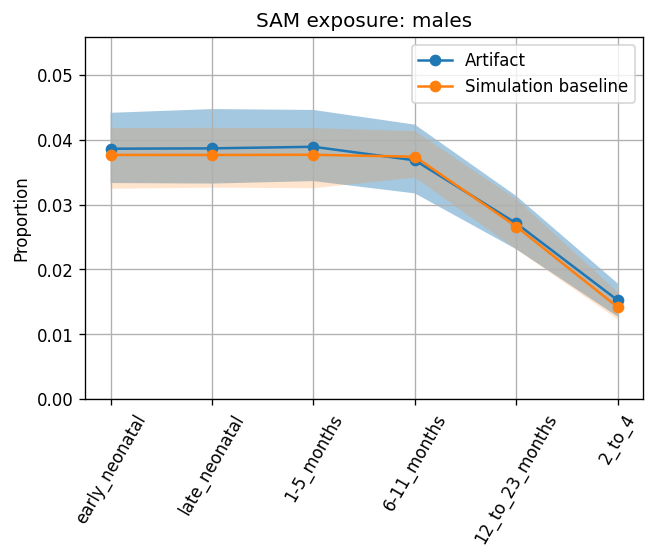

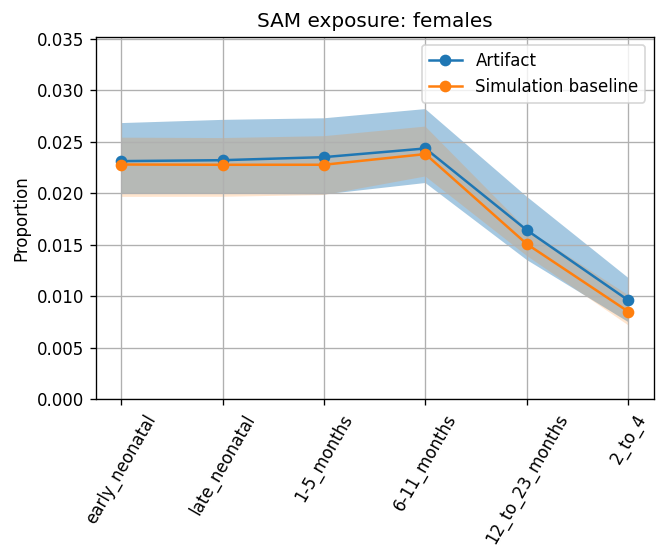

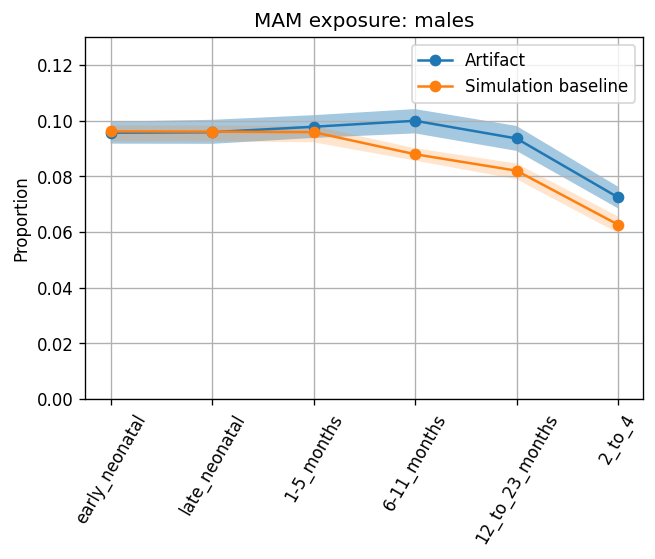

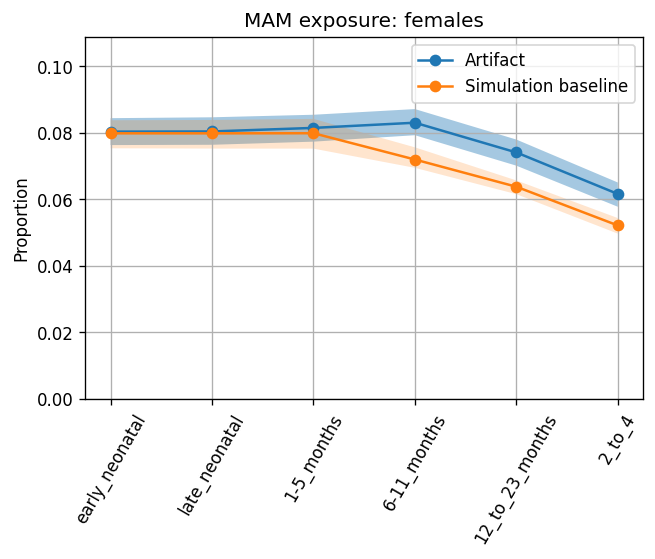

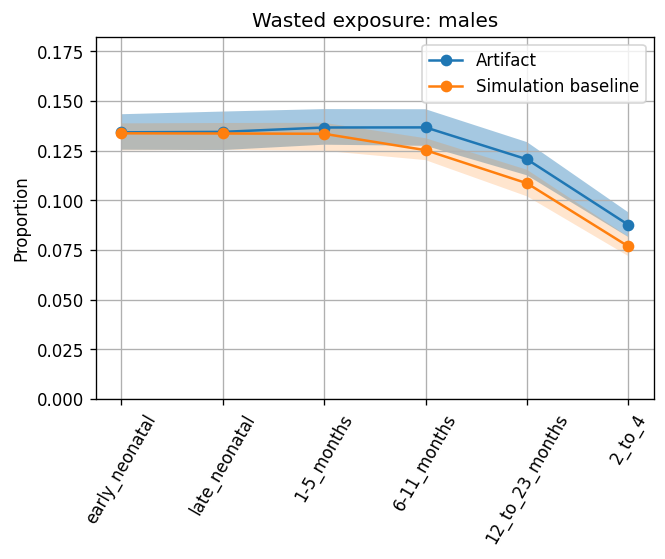

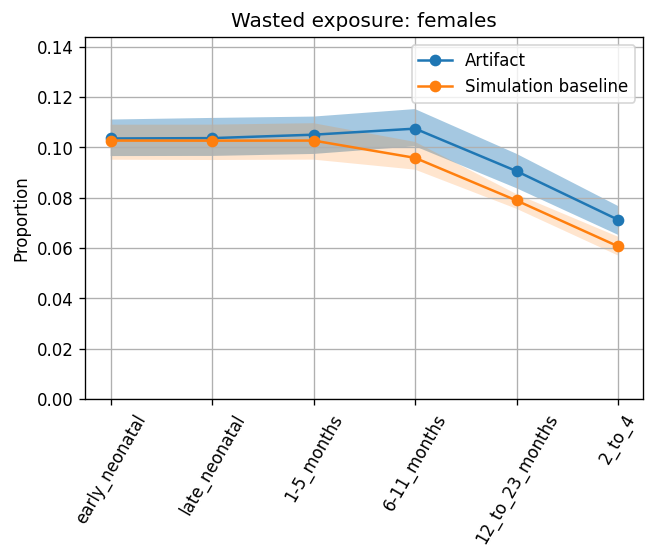

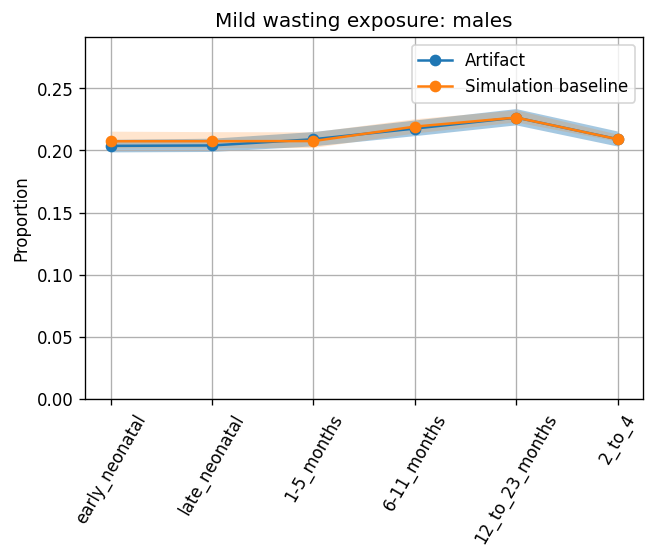

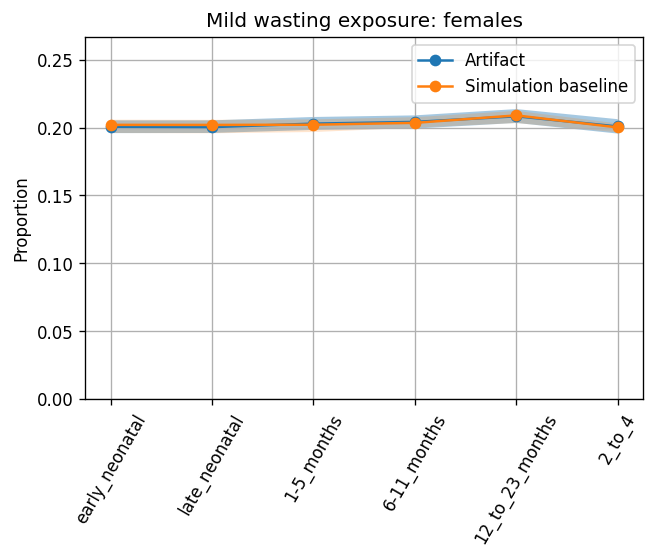

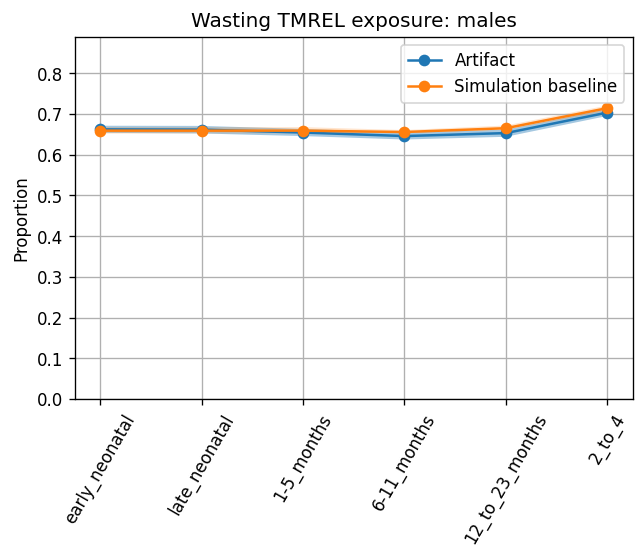

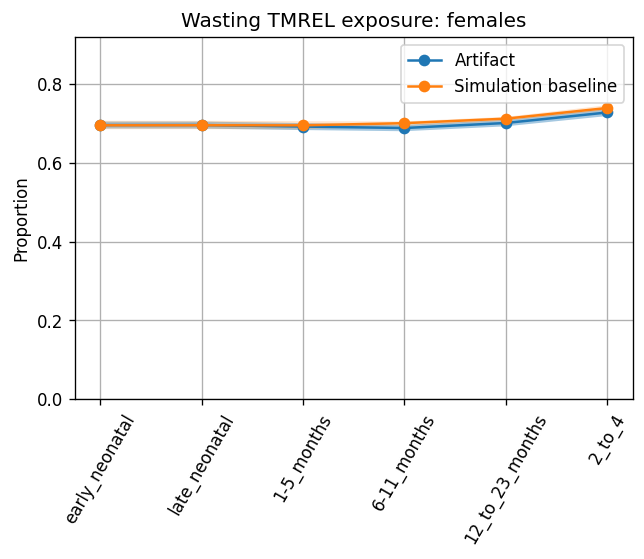

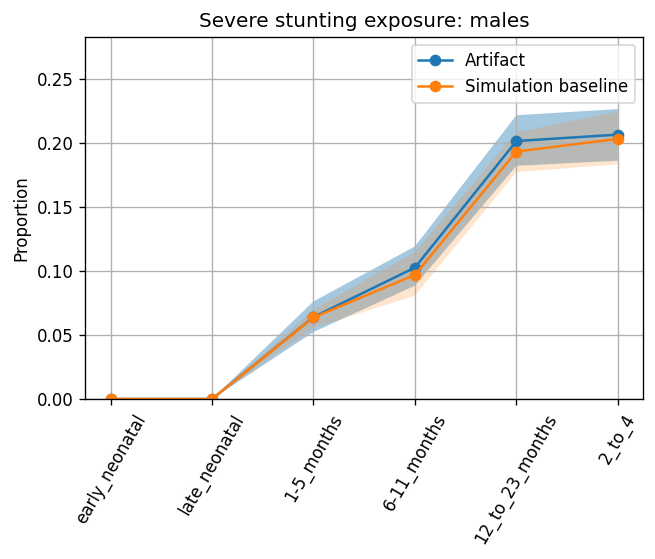

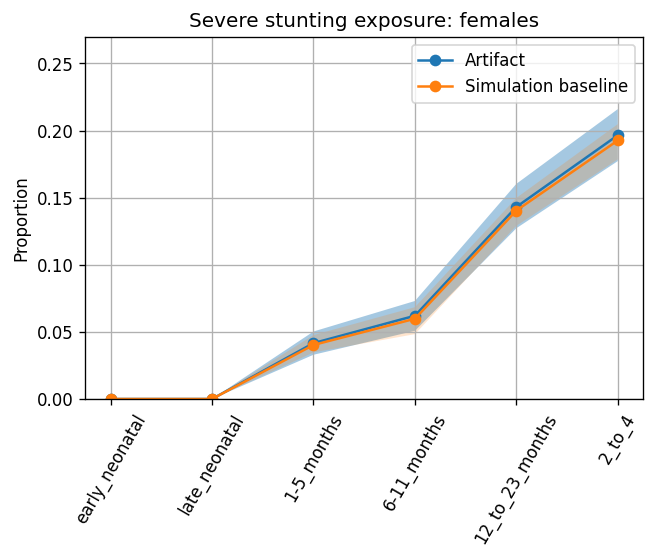

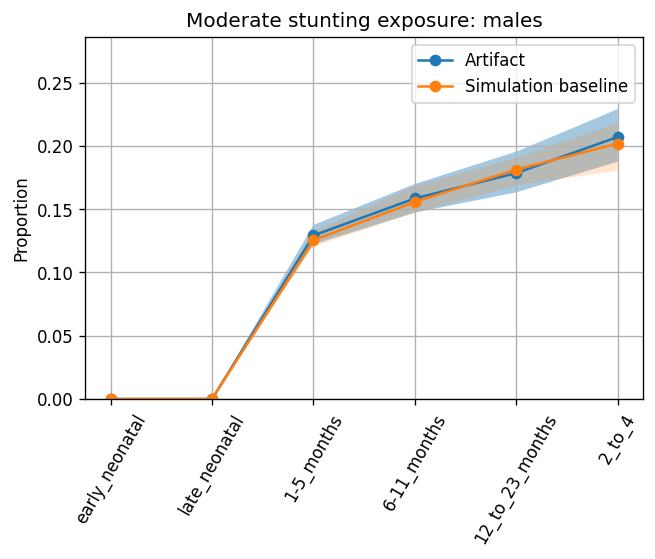

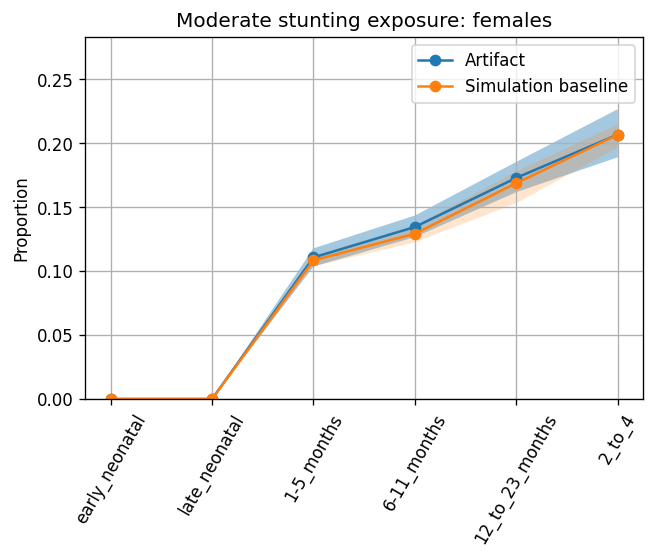

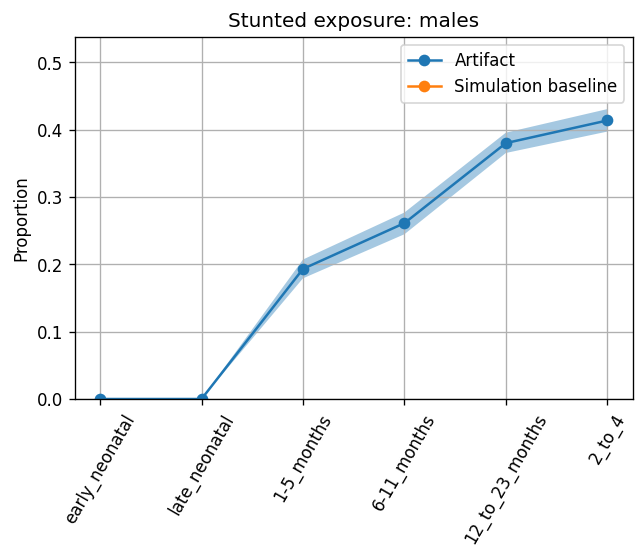

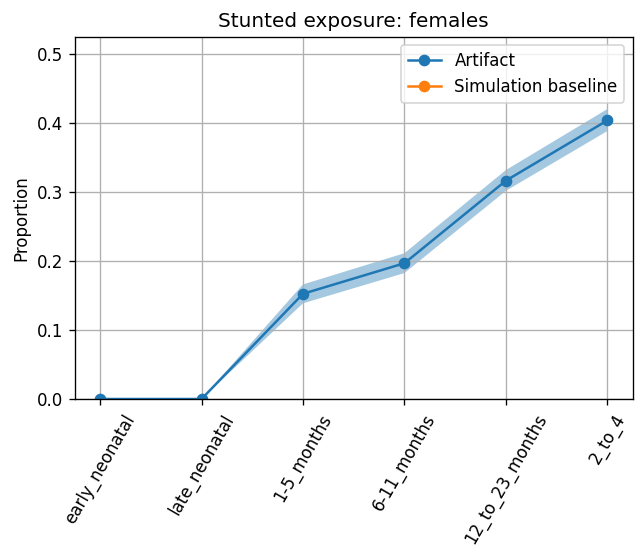

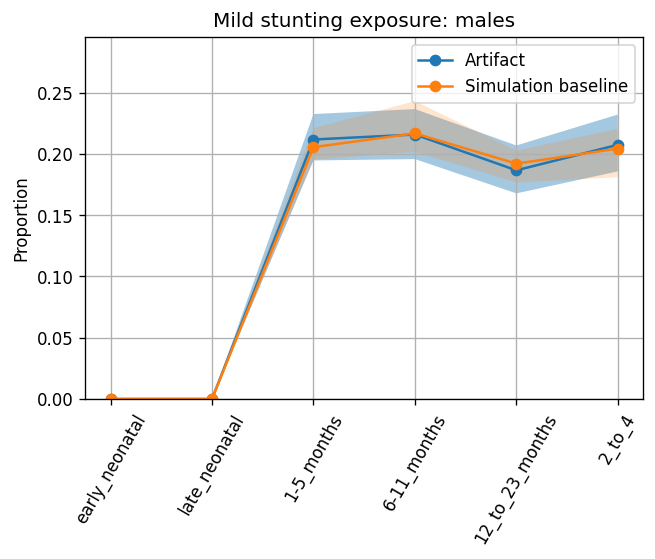

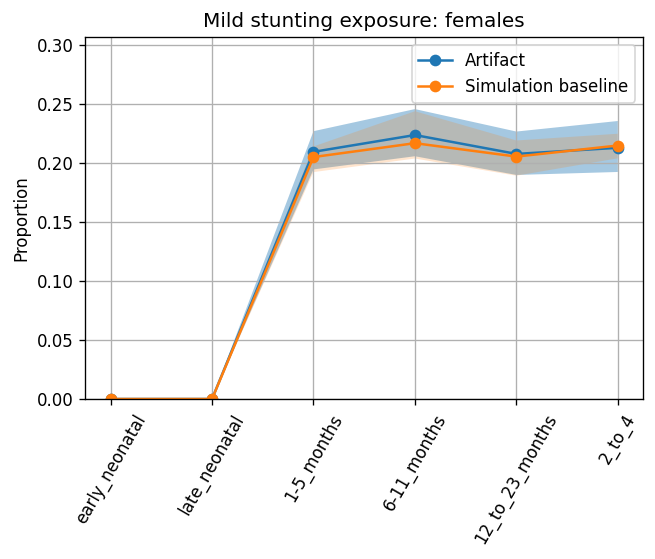

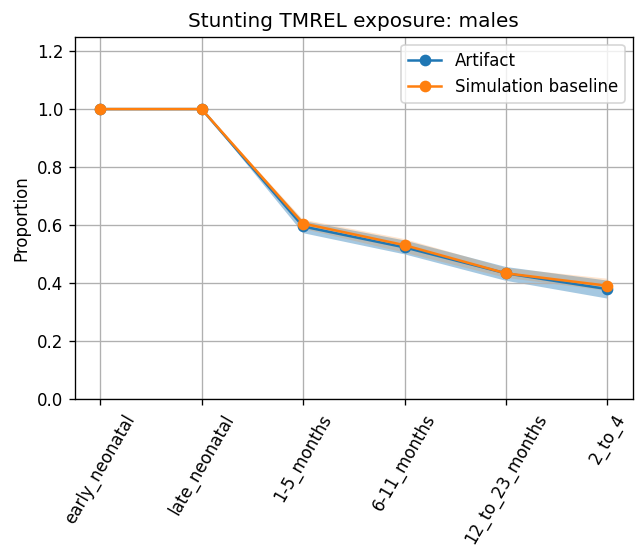

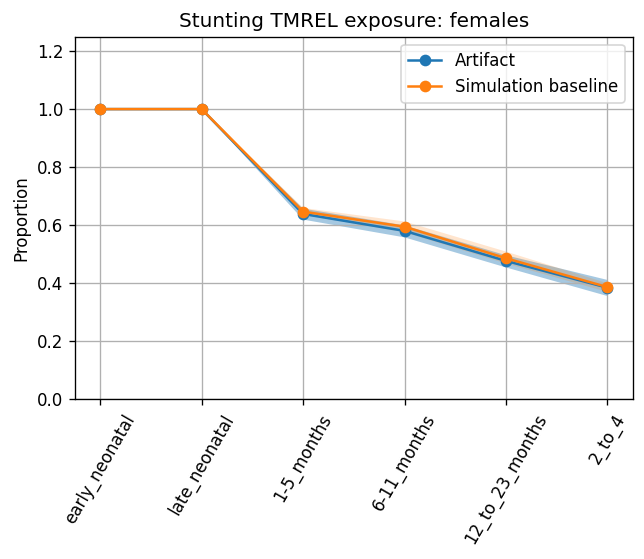

In [57]:
w_sim_cats = ['severe_acute_malnutrition','moderate_acute_malnutrition','wasted',
              'mild_child_wasting','susceptible_to_child_wasting']
art_cats = ['cat1','cat2','exposed','cat3','cat4']
w_title_cats = ['SAM','MAM','Wasted','Mild wasting','Wasting TMREL']
s_title_cats = ['Severe stunting','Moderate stunting','Stunted','Mild stunting','Stunting TMREL']

with PdfPages(f'{figname}_exposure.pdf') as pdf:
    for i in list(range(0,len(art_cats))):
        for sex in ['male','female']:
            plot_cgf_exposure(wasting_prev, wasting_art, f'{sex}', art_cats[i],
                              w_sim_cats[i], w_title_cats[i])
            pdf.savefig(bbox_inches='tight')
    for i in list(range(0,len(art_cats))):
        for sex in ['male','female']:
            plot_cgf_exposure(stunting_prev, stunting_art, f'{sex}', 
                              art_cats[i], art_cats[i], s_title_cats[i])
            pdf.savefig(bbox_inches='tight')

# Cause model verification

In [58]:
def load_artifact_cause_data(measure, cause):
    data = art.load(f'cause.{cause}.{measure}')
    data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data['age'] = 0
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))
    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    data['measure'] = measure
    data['cause'] = cause
    return data

In [59]:
artifact_data = pd.DataFrame()
causes=['diarrheal_diseases','lower_respiratory_infections','protein_energy_malnutrition','measles']
measures=['prevalence','incidence_rate','remission_rate',
               'cause_specific_mortality_rate','excess_mortality_rate']
for cause in causes:    
    for measure in measures:
        try:
            temp = load_artifact_cause_data(measure, cause)
            artifact_data = pd.concat([artifact_data,temp], ignore_index=True)
        except:
            pass

artifact_data.head()

sex  age_start   age_end  year_start  year_end      mean      2.5%  \
0  female   0.000000  0.019178        2020      2021  0.021082  0.018352   
1  female   0.019178  0.076712        2020      2021  0.046737  0.039978   
2  female   0.076712  0.500000        2020      2021  0.045650  0.038413   
3  female   0.500000  1.000000        2020      2021  0.045650  0.038413   
4  female   1.000000  2.000000        2020      2021  0.026259  0.020612   

      97.5%              age  age_group     measure               cause  
0  0.023129   early_neonatal          1  prevalence  diarrheal_diseases  
1  0.054209    late_neonatal          2  prevalence  diarrheal_diseases  
2  0.053132       1-5_months          3  prevalence  diarrheal_diseases  
3  0.053132      6-11_months          4  prevalence  diarrheal_diseases  
4  0.033100  12_to_23_months          5  prevalence  diarrheal_diseases

In [60]:
groupby_cols = ['input_draw','sex','age']

In [61]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

Unnamed: 0     sex  year               cause measure  input_draw  scenario  \
0           0  female  2022  diarrheal_diseases   death          29  baseline   
1           1  female  2022  diarrheal_diseases   death          29  baseline   
2           2  female  2022  diarrheal_diseases   death          29  baseline   
3           3  female  2022  diarrheal_diseases   death          29  baseline   
4           4  female  2022  diarrheal_diseases   death          29  baseline   

   value                 wasting_state             age  
0    2.0  susceptible_to_child_wasting  early_neonatal  
1    1.0            mild_child_wasting  early_neonatal  
2    2.0   moderate_acute_malnutrition  early_neonatal  
3    0.0     severe_acute_malnutrition  early_neonatal  
4    4.0  susceptible_to_child_wasting   late_neonatal

In [62]:
def calculate_csmr():
    d = deaths.loc[deaths.scenario=='baseline']
    pem = d.loc[d.cause.str.contains('acute_malnutrition')]
    pem['cause'] = 'protein_energy_malnutrition'
    acmr = d.copy()
    acmr['cause'] = 'all_causes'
    d = pd.concat([d.loc[d.cause.isin(['diarrheal_diseases','lower_respiratory_infections','measles'])],
                  pem, acmr], ignore_index=True)
    d = d.groupby(groupby_cols + ['cause']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    d = ((d / pt)[['value']])
         #.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause'])
         #.describe(percentiles=[0.025,0.975]))
    return d

In [63]:
def calculate_transition_rates():
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [64]:
def calculate_prevalence(causes):
    s = state_pt.copy()
    s = s.loc[s.scenario=='baseline']
    prev = pd.DataFrame()
    for cause in causes:
        infected = state_pt.loc[state_pt.cause==cause].groupby(groupby_cols + ['cause']).sum()
        total = state_pt.loc[state_pt.cause.str.contains(cause)].groupby(groupby_cols).sum()
        temp = (infected / total)[['value']]#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause']).describe(percentiles=[0.025,0.975])
        prev = pd.concat([prev,temp])
    return prev

In [65]:
def calculate_child_growth_exposure_prevalence_by_draw(risk):
    state_pt = pd.read_csv(output_dir +f'{risk}_state_person_time.csv')
    state_pt = state_pt.loc[state_pt.scenario=='baseline']
    state_pt = state_pt.groupby(['input_draw','sex','age','cause']).sum()[['value']]
    prev = state_pt / state_pt.groupby(['input_draw','sex','age']).sum()
    #prev = prev.groupby(['sex','age','cause']).describe(percentiles=[0.025,0.975])
    return prev

In [66]:
csmr = calculate_csmr()
trans = calculate_transition_rates()
prev = calculate_prevalence(['diarrheal_diseases','measles','lower_respiratory_infections'])
pem_prev = calculate_child_growth_exposure_prevalence_by_draw('wasting').reset_index()
pem_prev = (pem_prev.loc[pem_prev.cause.str.contains('acute_malnutrition')]
            .groupby(['input_draw','sex','age']).sum().reset_index())
pem_prev['cause'] = 'protein_energy_malnutrition'
prev = pd.concat([prev.reset_index(), pem_prev], ignore_index=True).set_index(groupby_cols + ['cause'])
remission = trans / prev
emr = csmr / prev

prev=prev.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause']).describe(percentiles=[0.025,0.975])
trans=trans.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
remission=remission.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
emr=emr.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause']).describe(percentiles=[0.025,0.975])
csmr=csmr.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause']).describe(percentiles=[0.025,0.975])

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
def plot_cause_data(measure, cause, sex):
    
    a = artifact_data.loc[artifact_data.sex==sex].loc[artifact_data.measure==measure].loc[artifact_data.cause==cause]
    assert len(a)>0
    plt.figure(dpi=120)
    plt.plot(a['age'], a['mean'], marker='o', label='Artifact data')
    plt.fill_between(a['age'], a['2.5%'], a['97.5%'], alpha=0.2)
    
    if measure=='cause_specific_mortality_rate':
        sim_data = csmr.copy()
    elif measure=='prevalence':
        sim_data=prev.copy()
    elif measure=='incidence_rate':
        sim_data=trans.reset_index().loc[trans.reset_index().measure=='incidence']
    elif measure=='remission_rate':
        sim_data=remission.reset_index().loc[remission.reset_index().measure=='remission']
    elif measure=='excess_mortality_rate':
        sim_data = emr.copy()
    s = sim_data.reset_index()
    s['order'] = np.where(s.age=='early_neonatal', 0,
                     np.where(s.age=='late_neonatal', 1,
                             np.where(s.age=='1-5_months',2,
                                     np.where(s.age=='6-11_months',3,
                                             np.where(s.age=='12_to_23_months',4,5)))))
    s = s.sort_values(by=['order'])
    s = s.loc[s.sex==f'{sex}'].loc[s.cause==cause]
    plt.plot(s['age'], s['value','mean'], marker='o', label=f'Simulation baseline')
    plt.fill_between(s['age'], s['value','2.5%'], s['value','97.5%'], alpha=0.2)
    plt.grid()
    plt.xticks(rotation=60)
    plt.legend()
    cause_title = cause.replace('_',' ').capitalize()
    measure_title = measure.replace('_',' ')
    plt.title(f'{cause_title} {measure_title}\n{sex.capitalize()}s')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


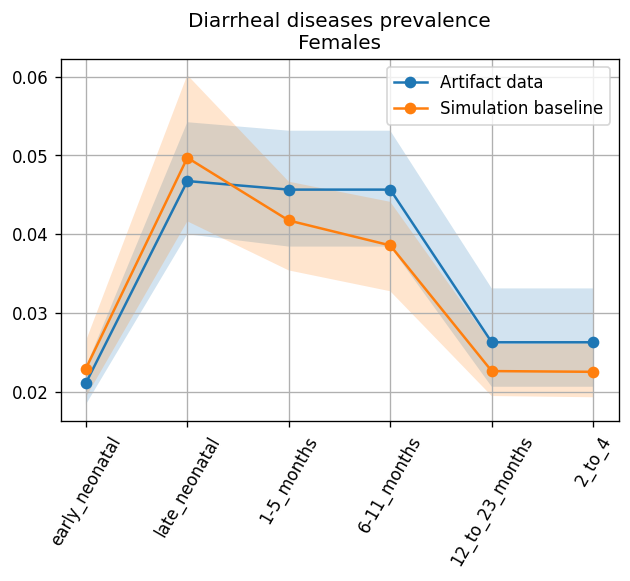

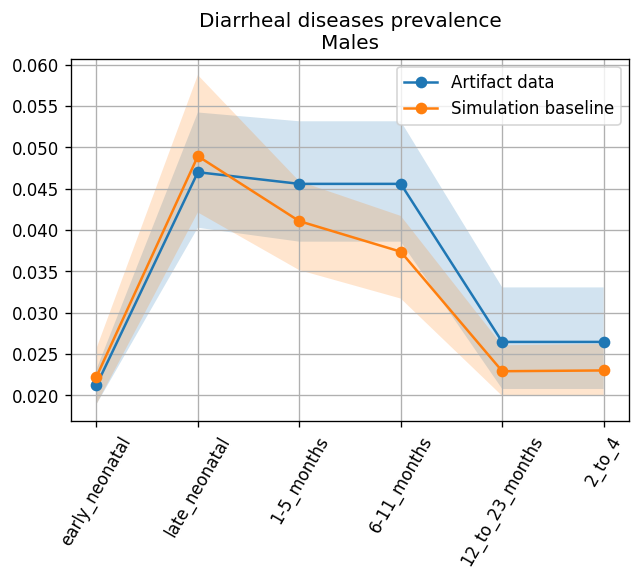

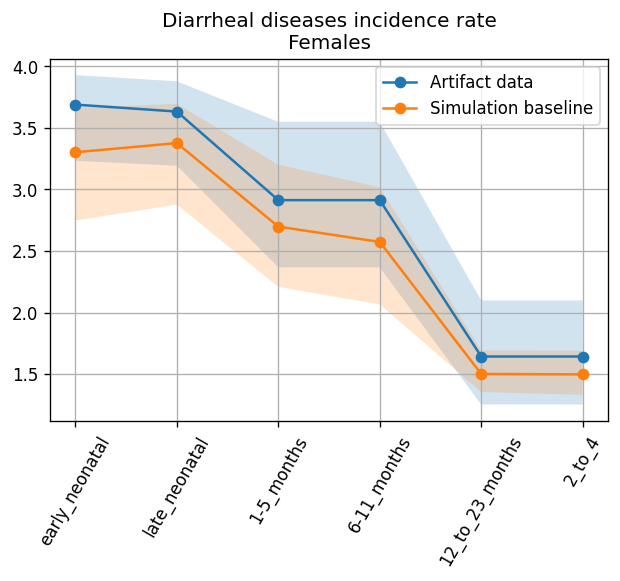

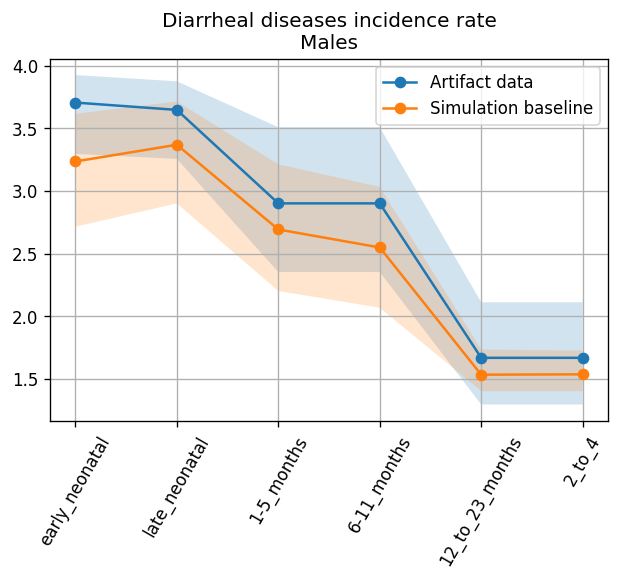

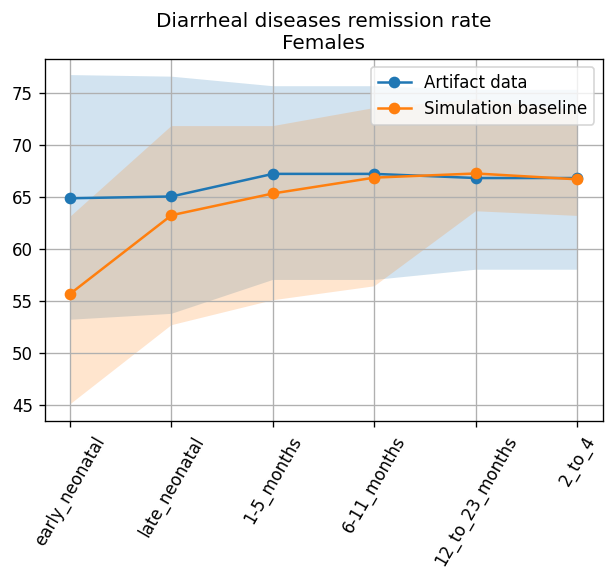

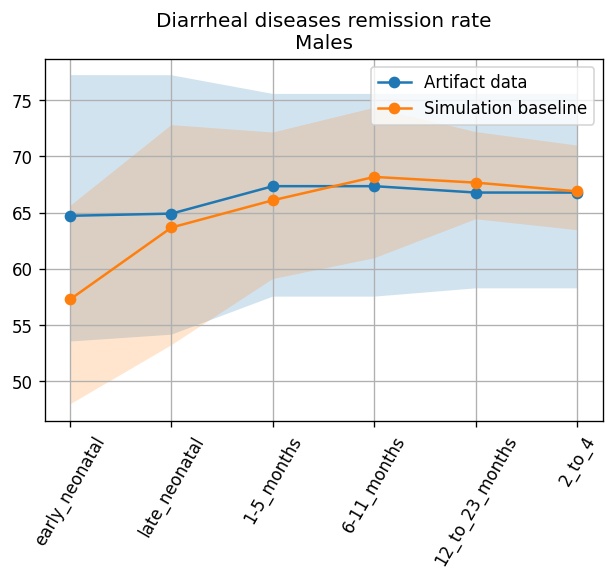

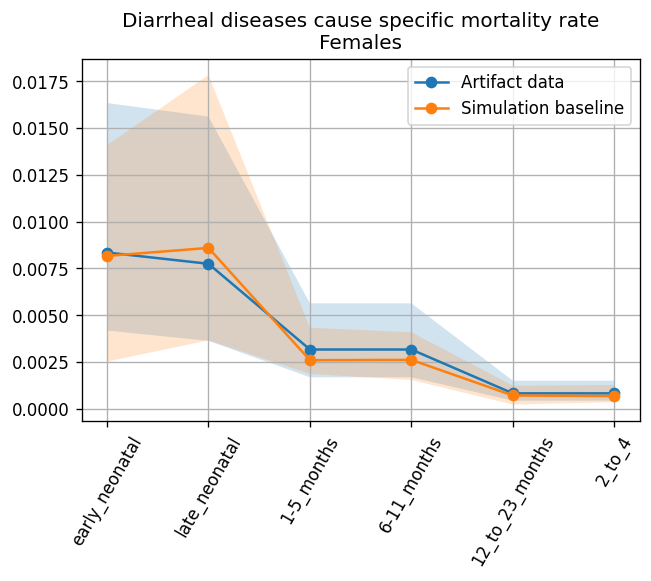

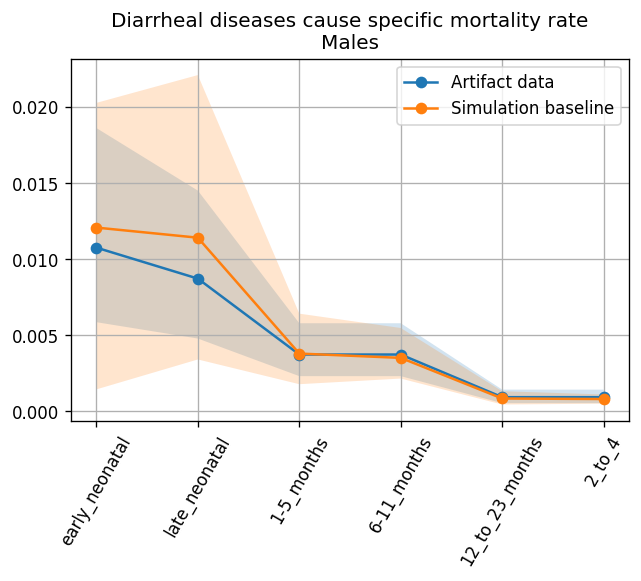

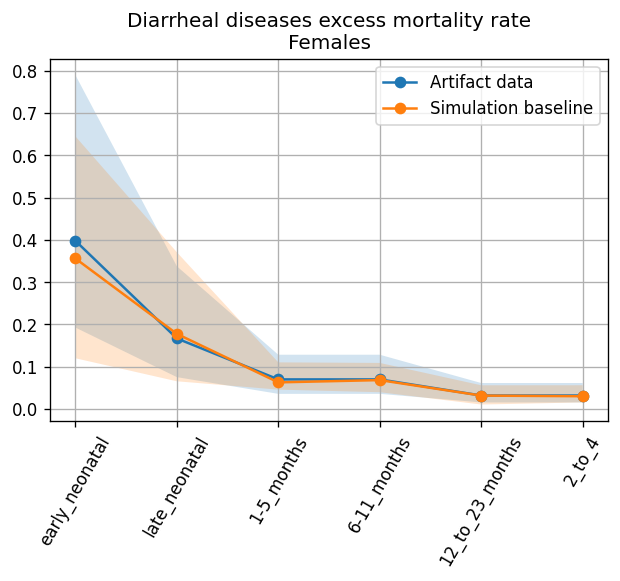

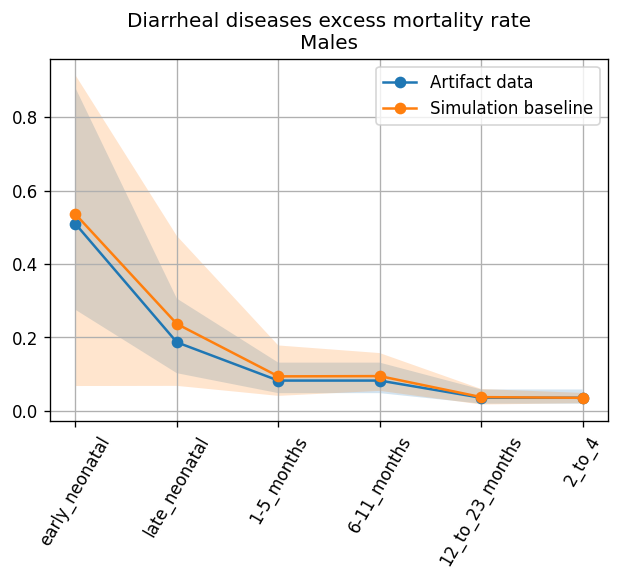

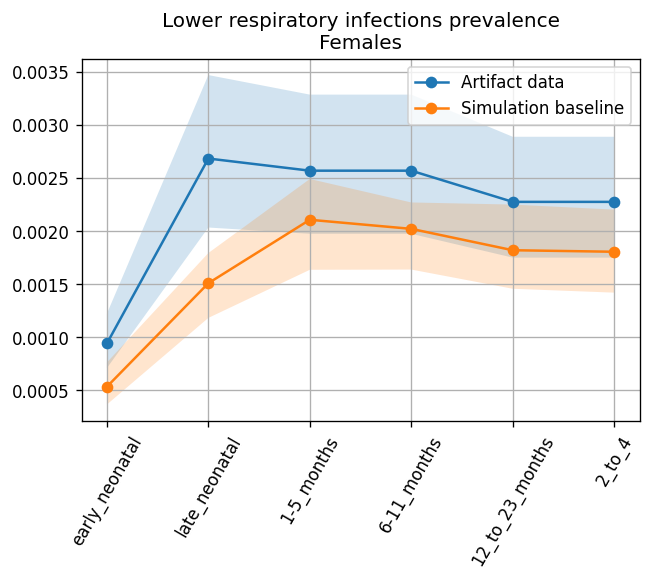

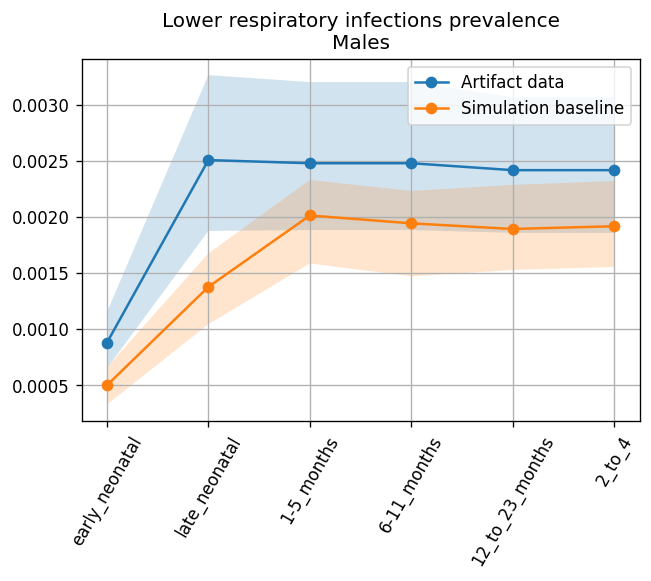

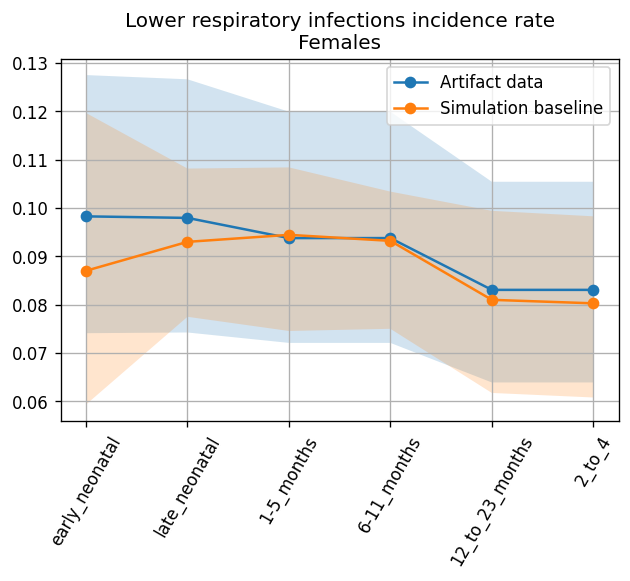

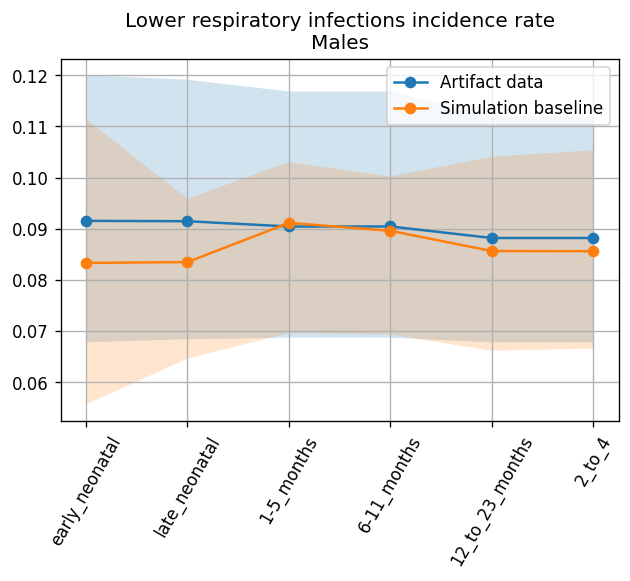

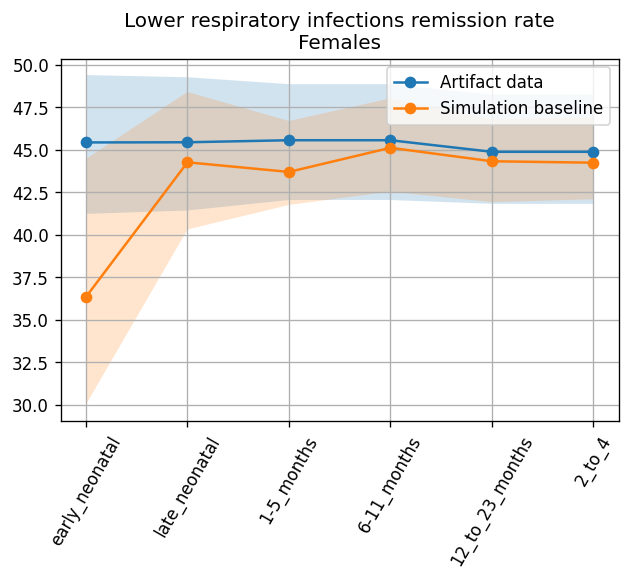

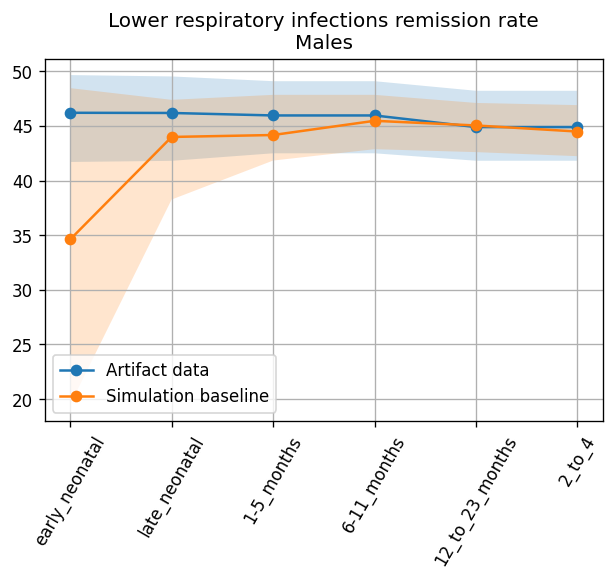

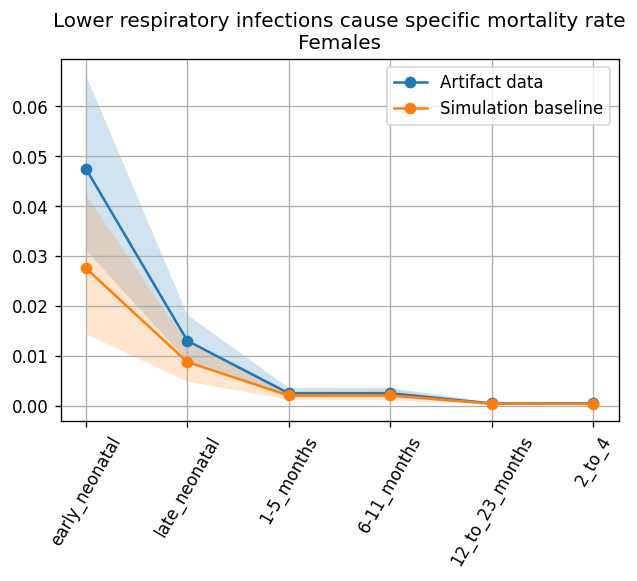

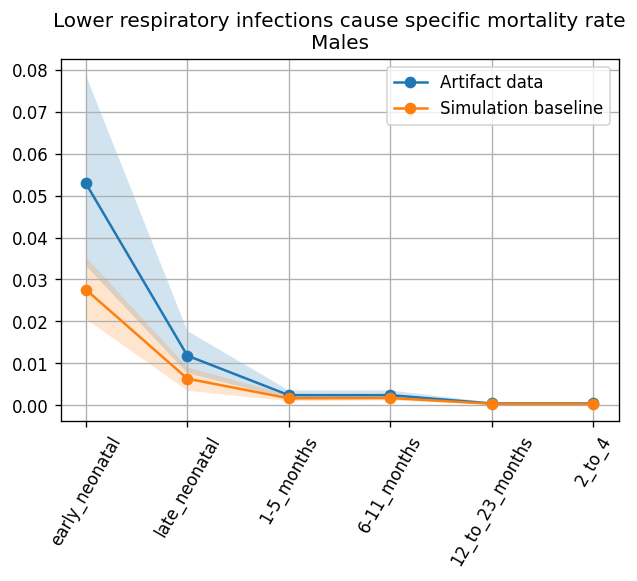

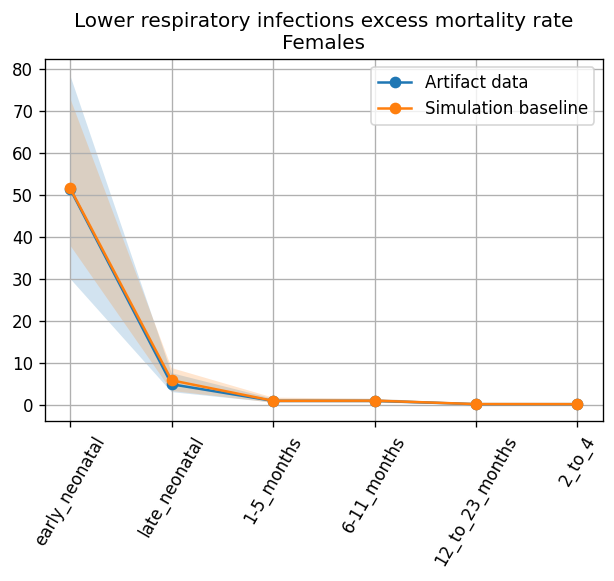

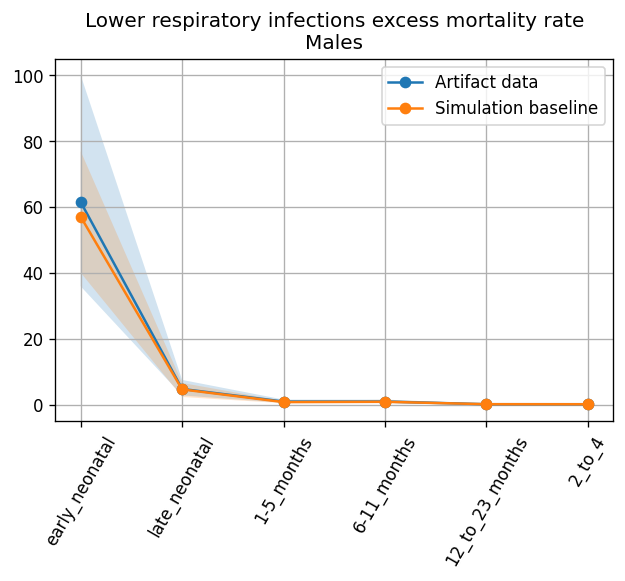

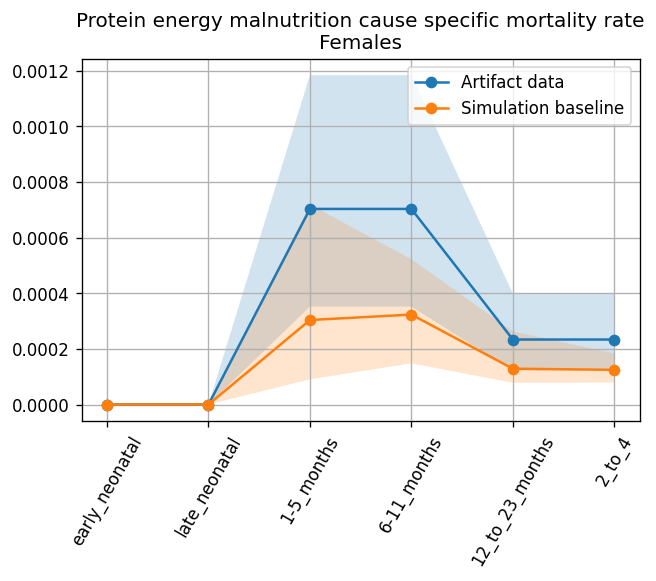

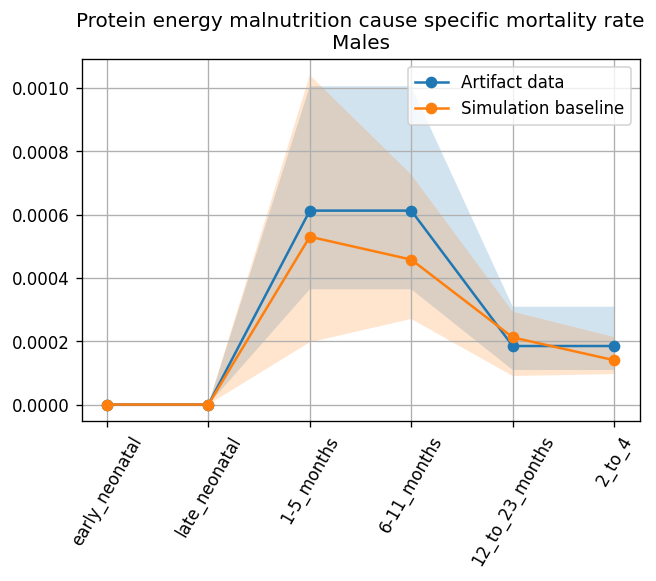

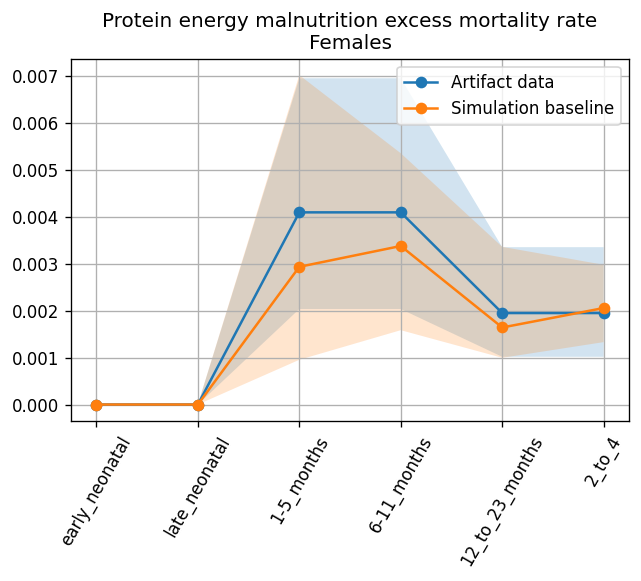

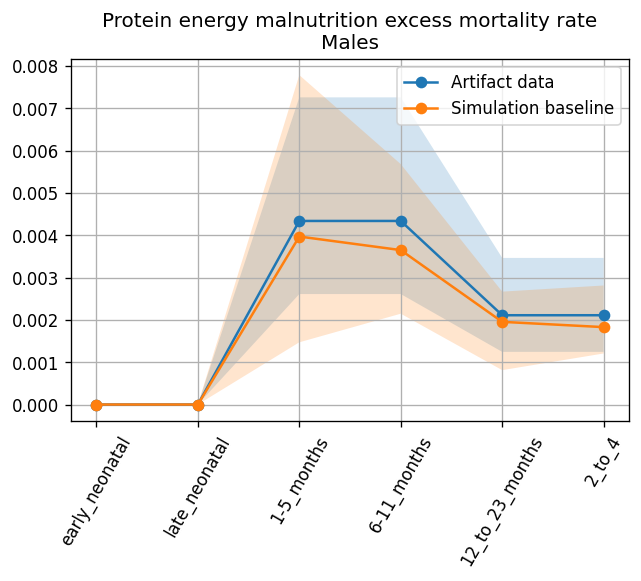

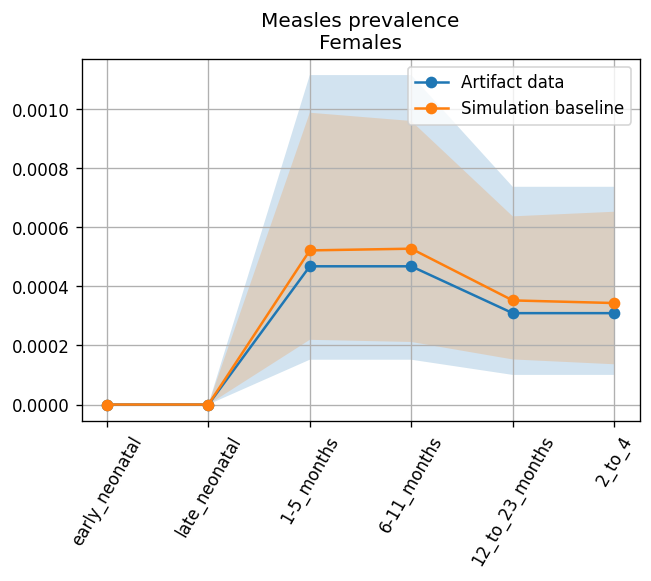

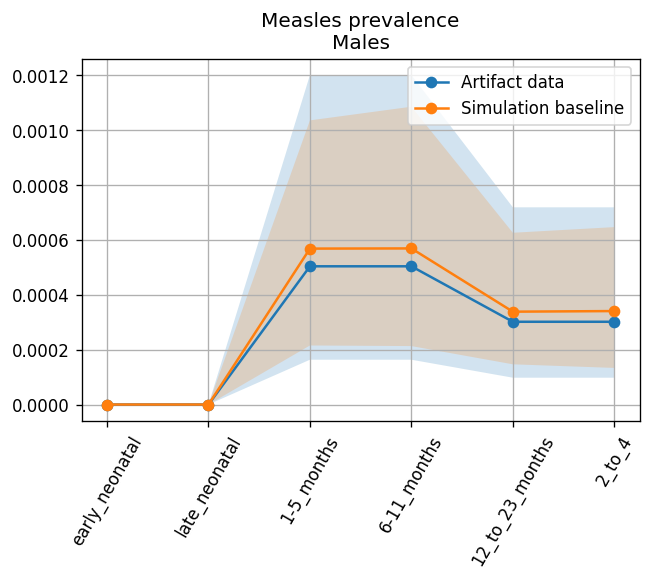

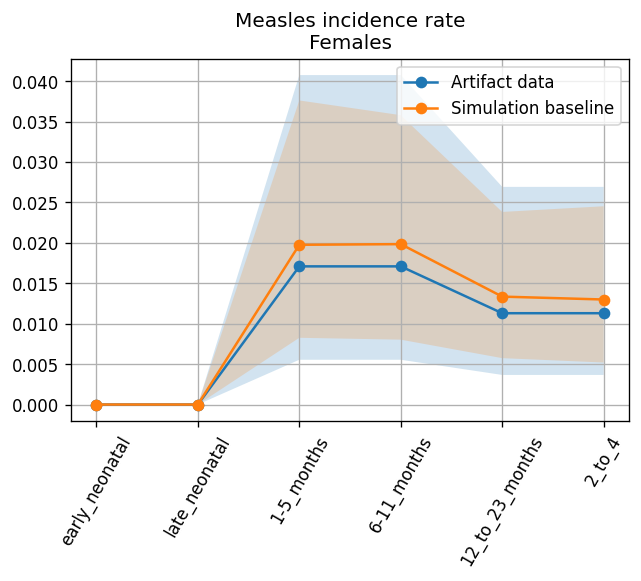

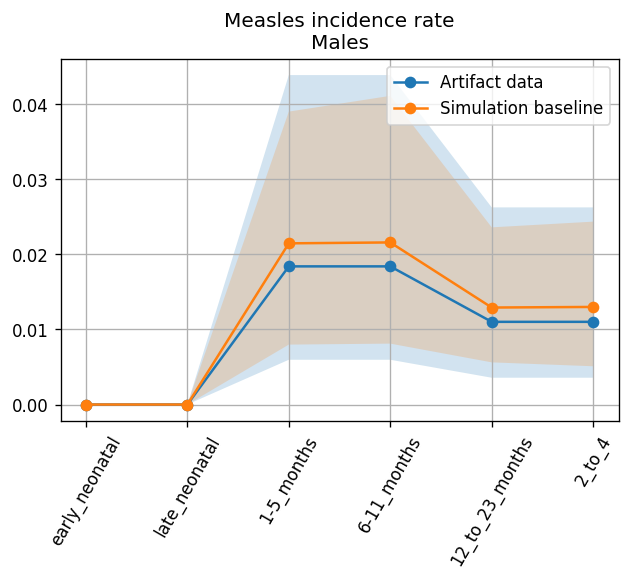

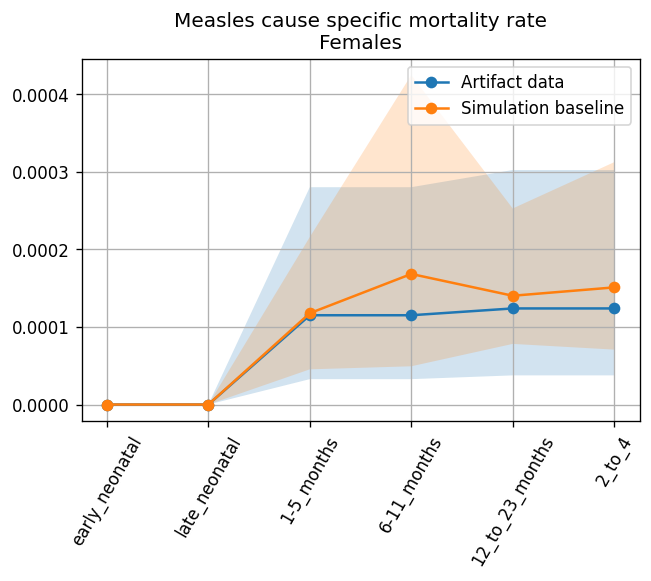

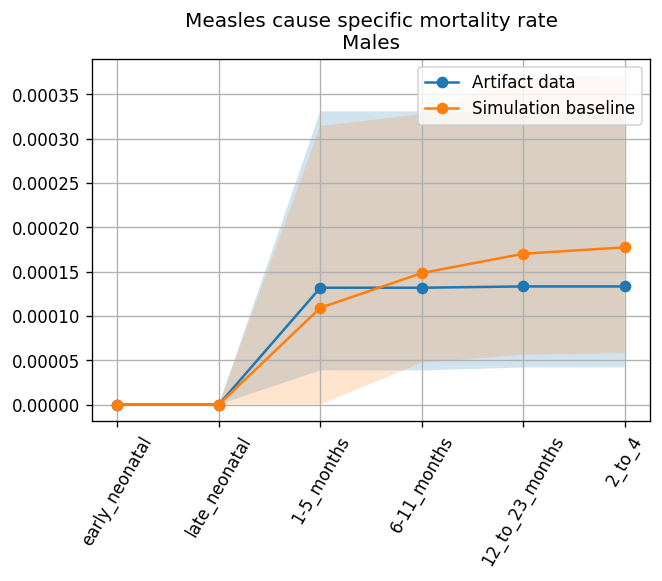

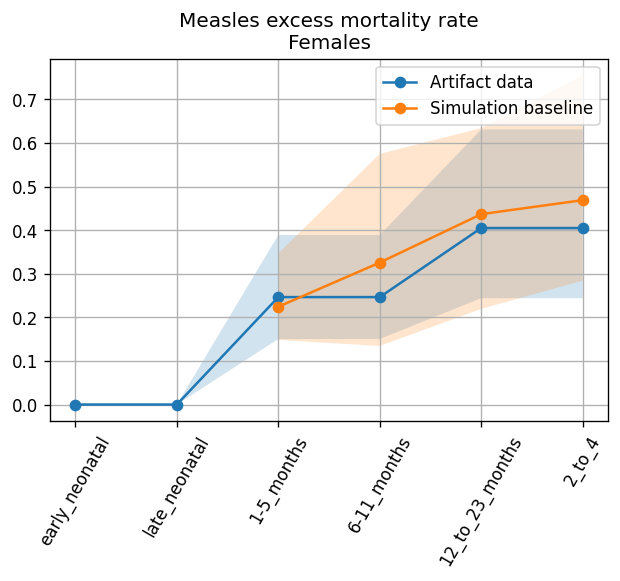

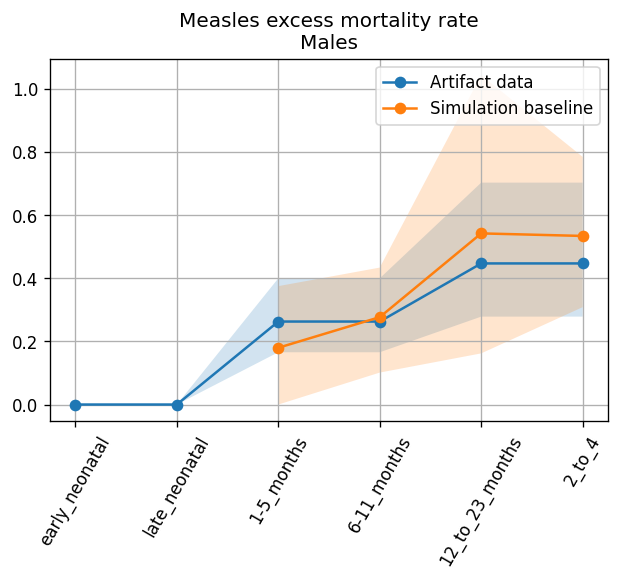

In [68]:
with PdfPages(f'{figname}_cause_verification.pdf') as pdf:
    causes=['diarrheal_diseases','lower_respiratory_infections','protein_energy_malnutrition','measles']
    measures=['prevalence','incidence_rate','remission_rate',
                   'cause_specific_mortality_rate','excess_mortality_rate']
    for cause in causes:
        for measure in measures:
            for sex in ['female','male']:
                try:
                    plot_cause_data(measure, cause, sex)
                    pdf.savefig(bbox_inches='tight')
                except:
                    pass

# Measles by year

In [69]:
groupby_cols = ['input_draw', 'sex', 'age','year']
csmr = calculate_csmr().groupby([c for c in groupby_cols if c != 'input_draw']+['cause']).describe(percentiles=[0.025,0.975]).reset_index()
prev = (calculate_prevalence(['diarrheal_diseases','measles','lower_respiratory_infections'])
        .groupby([c for c in groupby_cols if c != 'input_draw']+['cause']).describe(percentiles=[0.025,0.975]).reset_index())
trans = calculate_transition_rates().groupby([c for c in groupby_cols if c != 'input_draw']+['cause','measure']).describe(percentiles=[0.025,0.975]).reset_index()
csmr.head()

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


sex         age  year                         cause value            \
                                                          count      mean   
0  female  1-5_months  2022                    all_causes  12.0  0.011821   
1  female  1-5_months  2022            diarrheal_diseases  12.0  0.002829   
2  female  1-5_months  2022  lower_respiratory_infections  12.0  0.002164   
3  female  1-5_months  2022                       measles  12.0  0.000151   
4  female  1-5_months  2022   protein_energy_malnutrition  12.0  0.000303   

                                                               
        std       min      2.5%       50%     97.5%       max  
0  0.001987  0.008179  0.008518  0.012221  0.015216  0.015915  
1  0.001265  0.001136  0.001198  0.002973  0.005029  0.005463  
2  0.000818  0.001136  0.001193  0.002055  0.003510  0.003627  
3  0.000176  0.000000  0.000000  0.000114  0.000455  0.000457  
4  0.000223  0.000000  0.000062  0.000229  0.000783  0.000907

In [70]:
def plot_measures_by_year(cause, sex, age, measure):
    
    if measure=='cause_specific_mortality_rate':
        sim_data = csmr.copy()
    elif measure=='prevalence':
        sim_data=prev.copy()
    elif measure=='incidence_rate':
        sim_data=trans.reset_index().loc[trans.reset_index().measure=='incidence']
    elif measure=='remission_rate':
        sim_data=remission.reset_index().loc[remission.reset_index().measure=='remission']
    elif measure=='excess_mortality_rate':
        sim_data = emr.copy()
    plt.figure()
    p = (sim_data.loc[sim_data.cause==cause]
         .loc[sim_data.sex==sex]
         .loc[sim_data.age==age])
    a = (artifact_data.loc[artifact_data.measure==measure]
        .loc[artifact_data.cause==cause]
        .loc[artifact_data.sex==sex]
        .loc[artifact_data.age==age])
    plt.plot(p.year, list(a['mean']) * len(p.year), marker='o', label='Artifact data')
    plt.fill_between(p.year, list(a['2.5%']) * len(p.year), 
                     list(a['97.5%']) * len(p.year), alpha=0.25)

    plt.plot(p.year, p['value','mean'], marker='o', label='Simulation baseline')
    plt.fill_between(p.year, p['value','2.5%'], p['value','97.5%'], alpha=0.25)

    plt.legend()
    plt.xticks(p.year)
    plt.title(f'{cause} {measure}\n{sex}s {age}')

/ihme/code/alibow/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


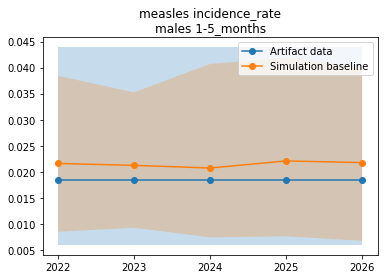

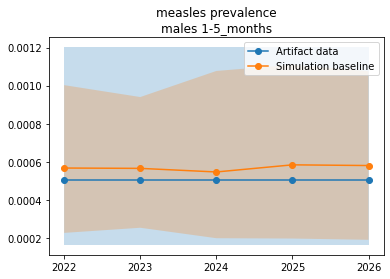

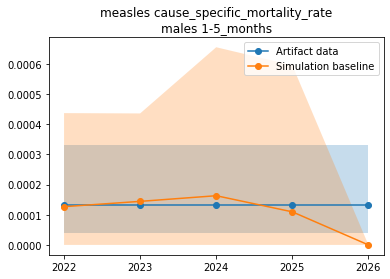

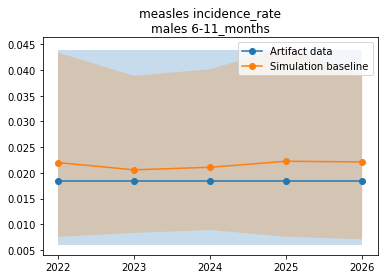

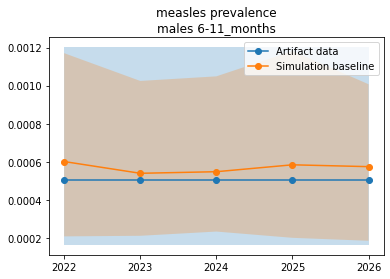

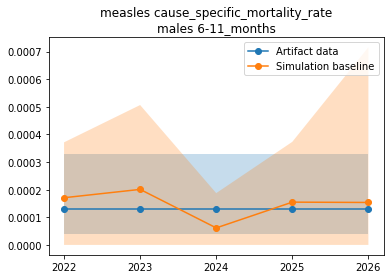

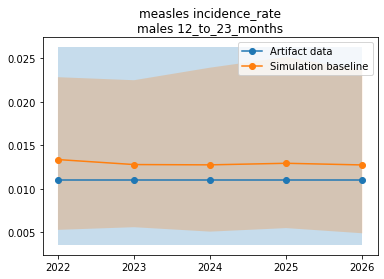

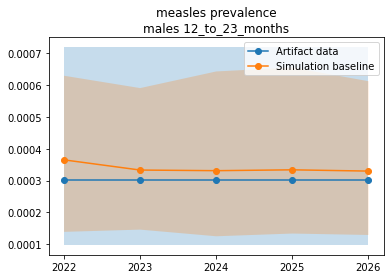

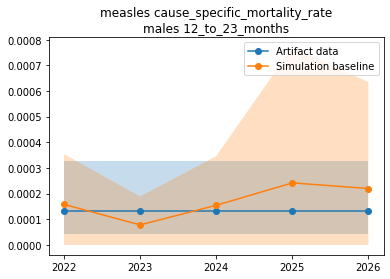

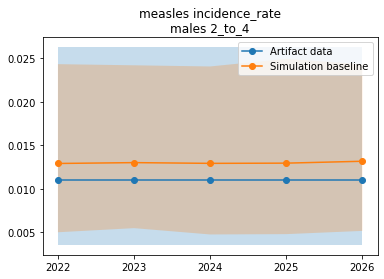

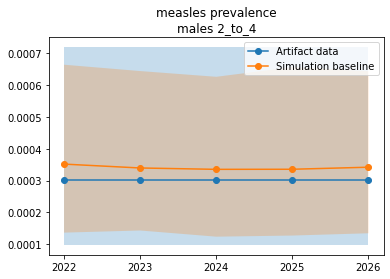

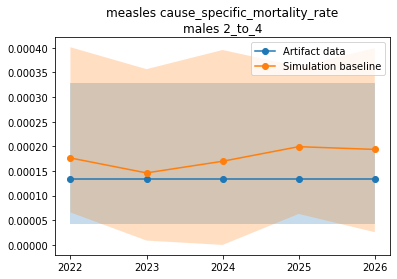

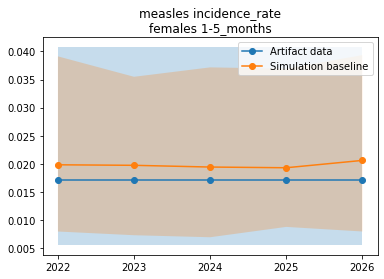

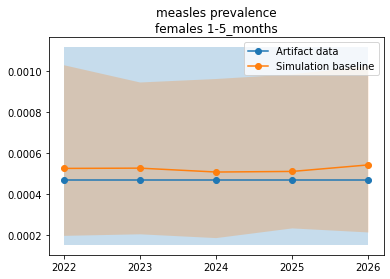

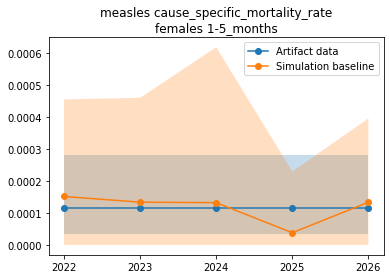

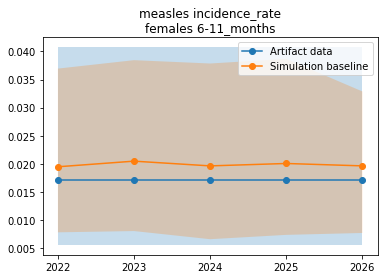

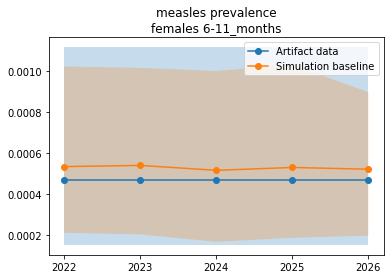

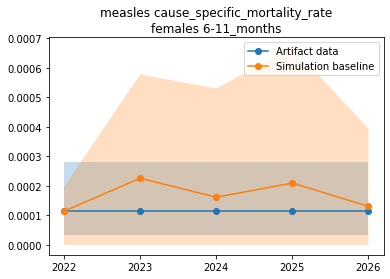

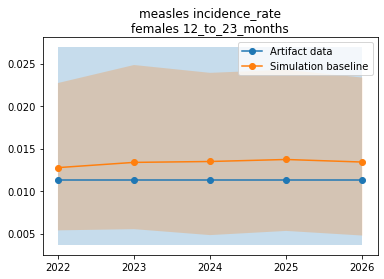

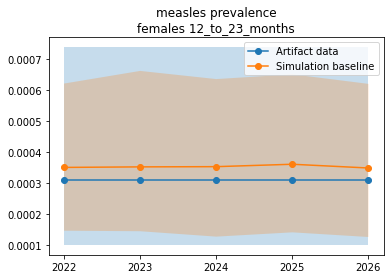

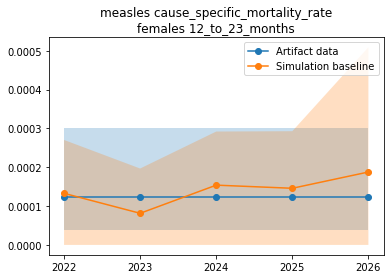

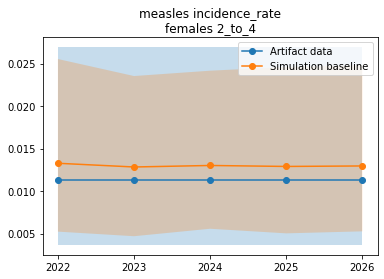

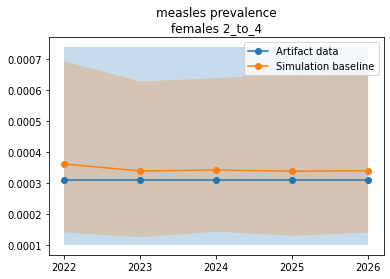

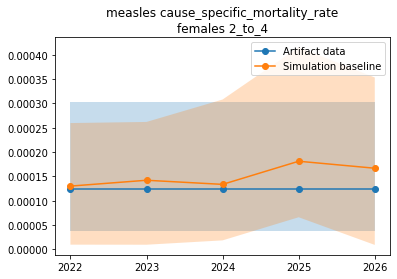

In [71]:
with PdfPages(f'measles_by_year_{figname}.pdf') as pdf:

    for sex in ['male','female']:
        for age in ['1-5_months', '6-11_months',
           '12_to_23_months', '2_to_4']:
            for measure in ['incidence_rate','prevalence','cause_specific_mortality_rate']:
                plot_measures_by_year(cause, sex, age, measure)
                pdf.savefig(bbox_inches='tight')